## Number classifier task

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sn

In [6]:
def extract_data(path):
    """Load data file"""
    return np.loadtxt(path, dtype=np.int16, delimiter=',')

def reshape_matrix(mat):
    """Reshape each line in the matrix into a quadratic image"""
    reshapedMat = []
    
    for i in range(np.size(mat,0)):
        reshapedMat.append(mat[i,:].reshape(28,28))

    return np.array(reshapedMat)

def knn(data_to_be_classified, labeled_data, k):
    """Get the k nearest neighbours of each datapoint to be classified"""
    n_samples = data_to_be_classified.shape[0]
    block_size = 500
    
    knn_idx = np.zeros((n_samples, k), dtype=int)

    for i in range(0, n_samples, block_size):

        distance = scipy.spatial.distance.cdist(data_to_be_classified[i:i+block_size], labeled_data, metric="euclidean")
        part = np.argpartition(distance, kth=k, axis=1)  # Sort element k correct, with all elements to the left of it smaller
        knn_idx[i:i+block_size] = part[:, :k]

    return knn_idx


def generate_conf_matrix(predicted_labels, true_labels):
    """Generate a confusion matrix for extended"""
    # 0-axis / y-axis: true class
    # 1-axis / x-axis: predicted class
    conf_matrix = np.zeros((10,10), dtype=int)

    for i in range(len(predicted_labels)):

        predicted_class = predicted_labels[i]        
        true_classs = true_labels[i]

        conf_matrix[true_classs][predicted_class] += 1
    
    return conf_matrix


def calc_error_rate(conf_matrix):
    """Calculate the total and per class error rate"""
    total_error_rate = (np.sum(conf_matrix) - np.trace(conf_matrix)) / np.sum(conf_matrix)
    class_error_rate = (np.sum(conf_matrix, axis=1) - np.diagonal(conf_matrix)) / np.sum(conf_matrix, axis=1)
    return total_error_rate, class_error_rate


def generate_conf_matrix_figure(conf_matrix, title):
    """Create a plt.Figure representation of the confusion matrix"""
    confusion_fig = plt.figure(figsize = (10,7))
    confusion_fig = sn.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    
    total_error_rate, _ = calc_error_rate(conf_matrix)
    confusion_fig.set_title(f"{title}. Error rate: {total_error_rate:.2%}")


    confusion_fig.set_ylabel("True class")
    confusion_fig.set_xlabel("Predicted class")

    confusion_fig.set_xticklabels(list(range(0,10)))
    confusion_fig.set_yticklabels(list(range(0,10)))
    return confusion_fig

In [7]:
# Load data
trainv = extract_data("numbers_data/trainv.csv")  
testv = extract_data("numbers_data/testv.csv")
trainlab = extract_data("numbers_data/trainlab.csv")
testlab = extract_data("numbers_data/testlab.csv")

### Classify all samples using NN

In [8]:
# Calculate results of only NN (KNN, K=1)
knn_idx = knn(data_to_be_classified=testv, labeled_data=trainv, k=1)
nn_idx = knn_idx[:, 0]  # Only one element is returned

nn_pred = trainlab[nn_idx]

##### Confusion matrix and error rates

Total error rate: 3.09%
Error rate 0: 0.71%
Error rate 1: 0.53%
Error rate 2: 3.88%
Error rate 3: 3.96%
Error rate 4: 3.87%
Error rate 5: 3.59%
Error rate 6: 1.46%
Error rate 7: 3.50%
Error rate 8: 5.54%
Error rate 9: 4.16%


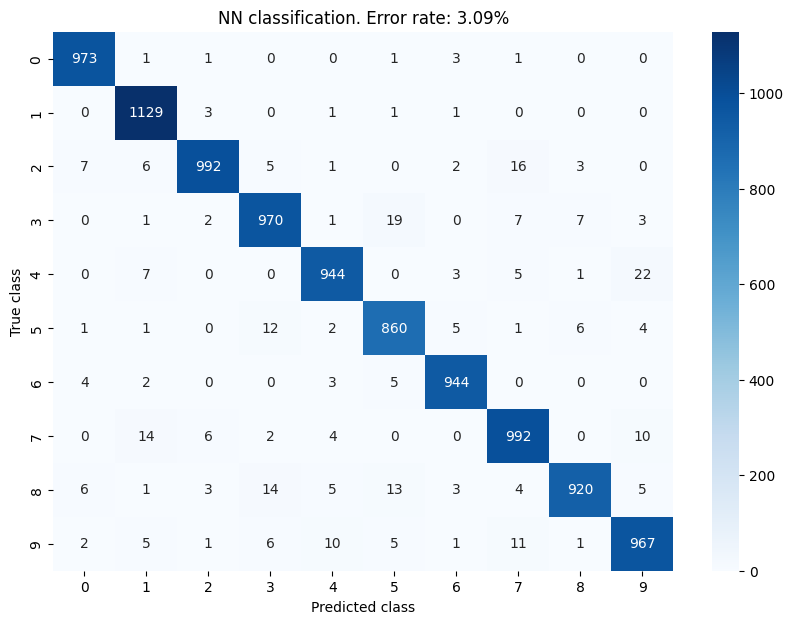

In [9]:
conf_matrix = generate_conf_matrix(nn_pred, testlab)
generate_conf_matrix_figure(conf_matrix, "NN classification")
total_error_rate, class_error_rate = calc_error_rate(conf_matrix)
print(f"Total error rate: {total_error_rate:.2%}")
for i, cls in enumerate(list(range(10))):
    print(f"Error rate {cls}: {class_error_rate[i]:.2%}")
    

##### Some correctly classified and missclassified images

Samples where true class is 9 and NN predicted 4: [1192 1232 1901 3160 3850 4314 4665 4823 5639 9808]


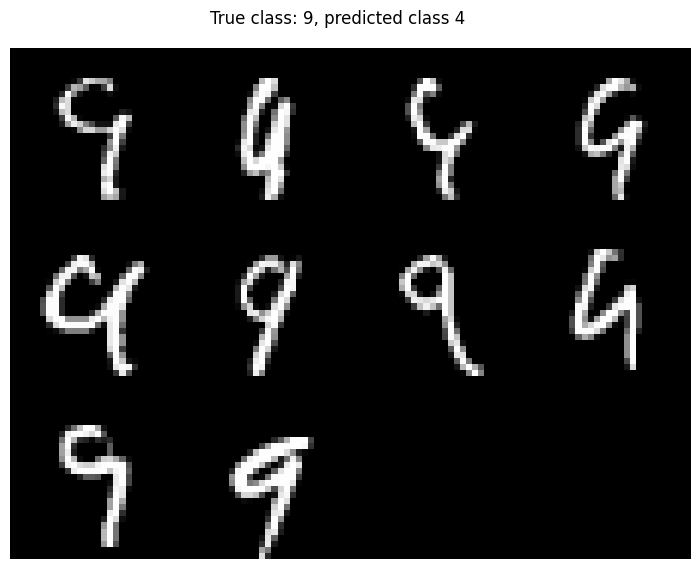

In [100]:
true_class = 9
predicted_class = 4

idxs = np.where((nn_pred == predicted_class) & (testlab == true_class))[0]
print(f"Samples where true class is {true_class} and NN predicted {predicted_class}: {idxs}")

cols = int(np.ceil(np.sqrt(len(idxs))))
rows = int(np.ceil(len(idxs)/cols))


fig = plt.figure(figsize=(2*cols, 2*rows))
fig.suptitle(f"True class: {true_class}, predicted class {predicted_class}")
sup_image = np.zeros((rows*28, cols*28))
for r in range(rows):
    for c in range(cols):
        if (r*cols+c) >= len(idxs):
            continue

        idx = idxs[r*cols+c]
        sup_image[r*28:(r+1)*28, c*28:(c+1)*28] = testv[idx].reshape((28, 28))

plt.imshow(sup_image, cmap="grey")
plt.tight_layout()
plt.axis("off");

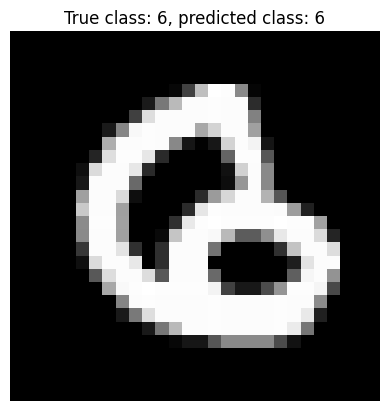

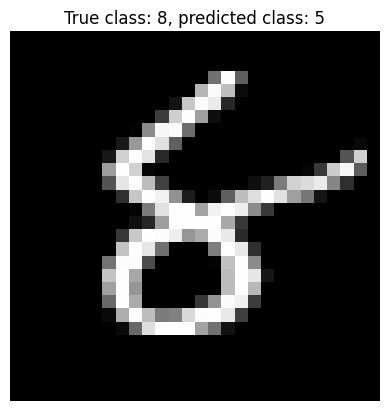

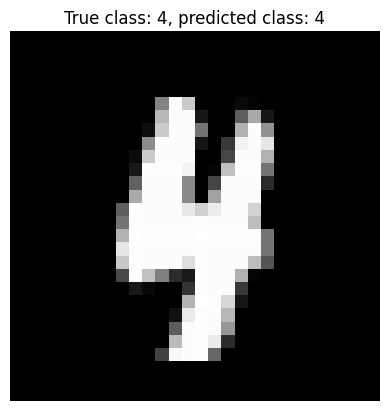

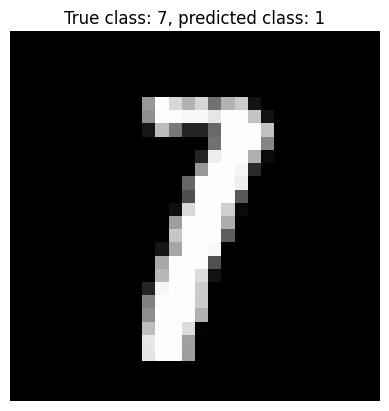

In [52]:
np.random.seed(20)
num_samples = 2
correctly_classified_idxs = np.where(nn_pred == testlab)[0]
incorrectly_classified_idxs = np.where(nn_pred != testlab)[0]

for i in range(num_samples):
    random_correct_idx = np.random.choice(correctly_classified_idxs)
    random_incorrect_idx = np.random.choice(incorrectly_classified_idxs)
    
    plt.figure()
    plt.imshow(testv[random_correct_idx].reshape((28, 28)), cmap='gray')
    plt.title(f"True class: {testlab[random_correct_idx]}, predicted class: {nn_pred[random_correct_idx]}")
    plt.axis("off")
    
    plt.figure()
    plt.imshow(testv[random_incorrect_idx].reshape((28, 28)), cmap='gray')
    plt.title(f"True class: {testlab[random_incorrect_idx]}, predicted class: {nn_pred[random_incorrect_idx]}")
    plt.axis("off")

#### K-means clustering

In [164]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def k_init_uniform(k):
    return np.random.uniform(0, 255, (k, 784))

def k_init_gaussian(k):
    P = 28
    x, y = np.mgrid[0:P, 0:P]
    pos = np.dstack((x, y))
    std = P/3
    rv = scipy.stats.multivariate_normal(mean=[P//2]*2, cov=np.diag([std**2, std**2]), seed=42)

    gauss = rv.pdf(pos)
    # Normalize, lose the normalization property
    gauss = (gauss - gauss.min()) / (gauss.max() - gauss.min())
    return np.random.uniform(0, 255, (k, 784)) * gauss.flatten()

def k_init_kpp(k):
    return 

def k_means(data, k, max_iterations, init_type="gaussian"):

    if init_type == "gaussian":
        centroids = k_init_gaussian(k)

    elif init_type == "uniform":
        centroids = k_init_uniform(k)
        
    elif init_type == "kpp":
        centroids=k_init_kpp(k)

    diff = np.zeros((max_iterations, k))
    iteration = 0

    while iteration < max_iterations:
        
        # For each sample in data, calculate the distance to each centroid
        distance_to_centroids = scipy.spatial.distance.cdist(data, centroids, metric='euclidean')
        # Assign each sample to the closest centroid
        cluster_idxs = np.argmin(distance_to_centroids, axis=1)
        
        # Iterate over each cluster
        for i in range(k):
            # Get all the datapoints belonging to this cluster
            cluster_data = data[cluster_idxs == i]
            # If any points belong to the cluster, update its center be the mean
            # of the points belonging to it
            if len(cluster_data):
                mean = np.mean(cluster_data, axis=0)
                diff[iteration][i] = np.linalg.norm(centroids[i] - mean)
                centroids[i] = mean
        iteration += 1
    
    return centroids, diff

def show_data_as_image(data, size, title, ylab, xlab, cmap, axis="off"):
    fig = plt.figure(figsize=size)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_ylabel(xlab)
    ax.set_xlabel(ylab)

    im = ax.imshow(data, cmap=cmap)
        
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    fig.colorbar(im, cax=cax)
    ax.axis(axis)

def display_convergence(diff, n, M):
    fig = plt.figure(figsize=(15,8))
    ax = plt.gca()
    ax.set_title(f"Change in 2-norm of each centroid for class {n}")
    ax.set_ylabel("Iteration")
    ax.set_xlabel("Centroid")

    im = ax.imshow(diff[:, n*M:(n+1)*M], cmap="RdBu")
        
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    fig.colorbar(im, cax=cax)

def display_centroids(centroids, n, M):
    p = int(np.ceil(np.sqrt(M)))
    fig = plt.figure(figsize=(p, p))
    fig.suptitle(f"Centroids for class: {n}")
    sup_image = np.zeros((p*28, p*28))
    for r in range(p):
        for c in range(p):
            idx = r*p+c

            sup_image[r*28:(r+1)*28, c*28:(c+1)*28] = centroids[n*M+idx].reshape((28, 28))

    plt.imshow(sup_image, cmap="grey")
    plt.tight_layout()
    plt.axis("off")


### Clustering

In [168]:
# Sort labeled data by class
trainv_by_class = []
for i in range(10):
    trainv_by_class.append(trainv[trainlab == i])

# Create M clusters for each class, run for clustering algorithm for N iterations
M = 64
N = 15

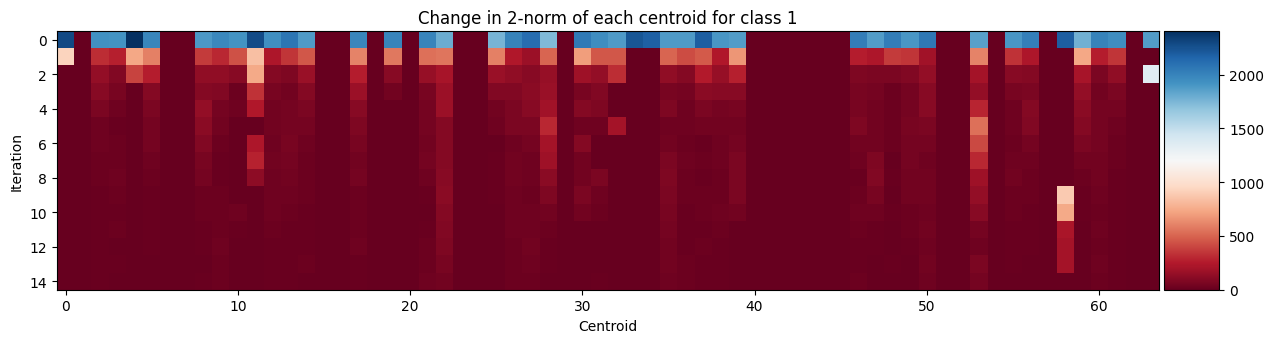

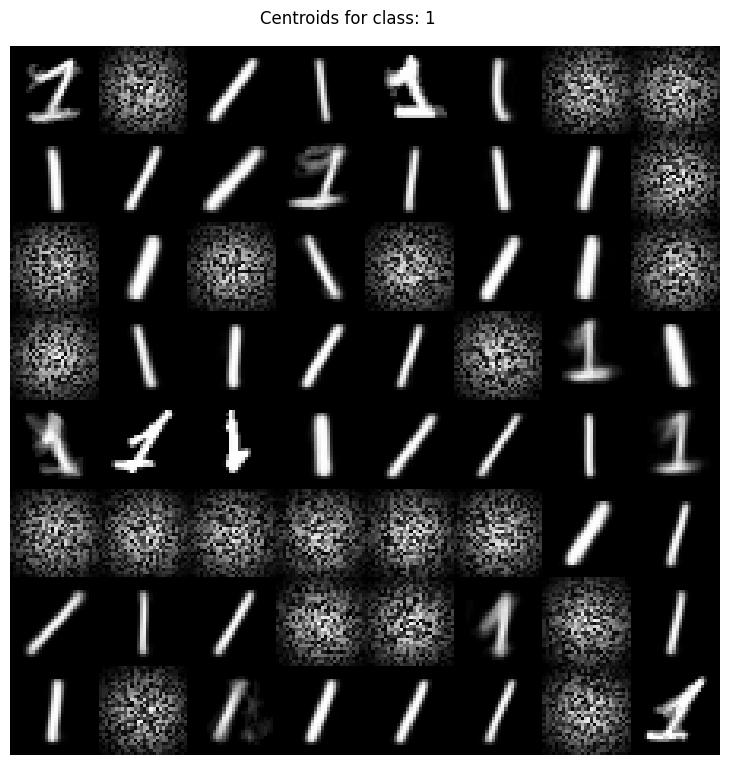

In [169]:
np.random.seed(42)

# Store the centroids sequentially
centroids = np.zeros((M*10, 784))
diff = np.zeros((N, M*10))

# Create labels for centroids
centroids_lab = np.zeros(M*10, dtype=int)
for i in range(10):
    centroids_lab[i*M:(i+1)*M] = [i]*M

# Perform clustering on each class
for i in range(10):
    centroids_class, diff_class = k_means(data=trainv_by_class[i], k=M, max_iterations=N)

    centroids[i*M:(i+1)*M] = centroids_class
    diff[:, i*M:(i+1)*M] = diff_class

n=1
display_convergence(diff, n, M)
display_centroids(centroids, n, M)
    

#### NN on clustered data

Total error rate: 4.53%
Error rate 0: 1.84%
Error rate 1: 0.35%
Error rate 2: 4.26%
Error rate 3: 5.64%
Error rate 4: 5.91%
Error rate 5: 5.27%
Error rate 6: 2.51%
Error rate 7: 6.32%
Error rate 8: 5.95%
Error rate 9: 7.73%


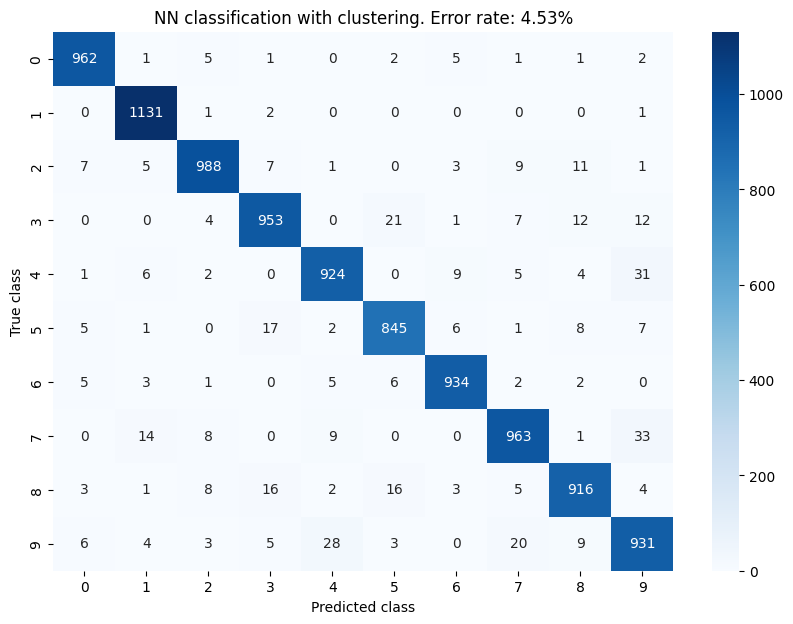

In [143]:
# k=1 implies we only find 1 neighbour
knn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=1)
nn_idx = knn_idx[:, 0]

nn_pred = centroids_lab[nn_idx]

conf_matrix = generate_conf_matrix(nn_pred, testlab)
generate_conf_matrix_figure(conf_matrix, "NN classification with clustering")
total_error_rate, class_error_rate = calc_error_rate(conf_matrix)
print(f"Total error rate: {total_error_rate:.2%}")
for i, cls in enumerate(list(range(10))):
    print(f"Error rate {cls}: {class_error_rate[i]:.2%}")
    


### KNN (K=7) on clustered data

Total error rate: 6.28%
Error rate 0: 2.55%
Error rate 1: 0.79%
Error rate 2: 6.88%
Error rate 3: 5.25%
Error rate 4: 7.43%
Error rate 5: 7.85%
Error rate 6: 3.65%
Error rate 7: 9.05%
Error rate 8: 9.34%
Error rate 9: 10.70%


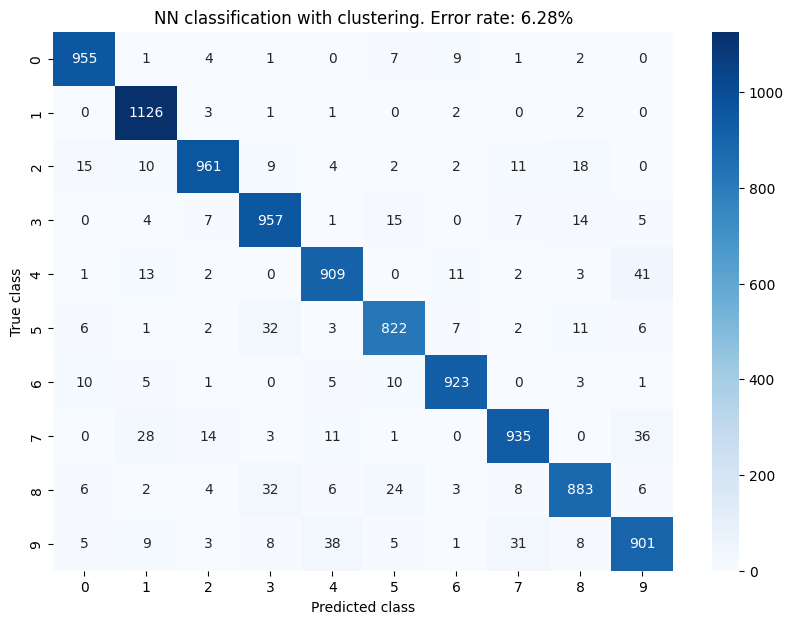

In [144]:
K = 7

knn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=K)
knn_idx = knn_idx.flatten(order="C")                        # Store the data sequentially to be able to get labels efficiently
knn_labels = centroids_lab[knn_idx]                         # Get label of all neighbours
knn_labels = knn_labels.reshape((int(1e4), K), order="C")   # Cast back into the original shape to take
knn_pred = scipy.stats.mode(knn_labels, axis=1).mode        # Get the most common neighbour

conf_matrix = generate_conf_matrix(knn_pred, testlab)
generate_conf_matrix_figure(conf_matrix, "NN classification with clustering")
total_error_rate, class_error_rate = calc_error_rate(conf_matrix)
print(f"Total error rate: {total_error_rate:.2%}")
for i, cls in enumerate(list(range(10))):
    print(f"Error rate {cls}: {class_error_rate[i]:.2%}")
    

#### Remarks regarding kmeans convergence

Instead of choosing a purley random noisy image, we can exploit that by inspection the numbers are more closley resembled by a 2D gaussian. A reasonable choice of gaussian (a symmetric one) gives huge improvements over the uniform one.

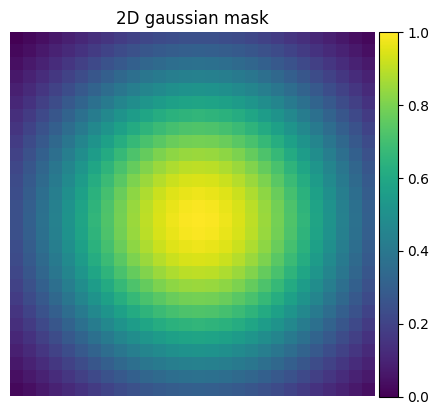

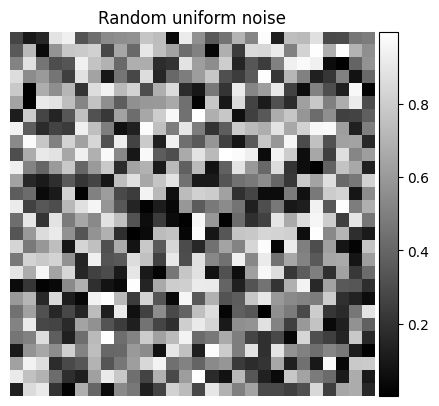

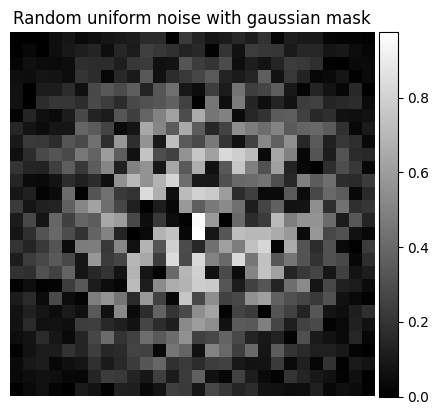

In [154]:
# 2D gaussian

P = 28
x, y = np.mgrid[0:P, 0:P]
pos = np.dstack((x, y))
# Create a 2D Gaussian with center in the middel of the image
# that vanished at the edges.
std = P/3
rv = scipy.stats.multivariate_normal(mean=[P//2]*2, cov=np.diag([std**2, std**2]), seed=42)

gauss = rv.pdf(pos)
# Normalize, lose the normalization property
gauss = (gauss - gauss.min()) / (gauss.max() - gauss.min())

show_data_as_image(gauss, (5,5), "2D gaussian mask", "", "", cmap=None)

random_imgs = np.random.uniform(0, 1, size=(10, P*P))
show_data_as_image(random_imgs[0].reshape((P,P)), (5,5), "Random uniform noise", "", "", cmap="gray")


# Multiply by weights to emphasize center
images_weighted = random_imgs * gauss.flatten()
show_data_as_image(images_weighted[0].reshape((P,P)), (5,5), "Random uniform noise with gaussian mask", "", "", cmap="gray")


### Uniform init

NN total error rate: 5.79%


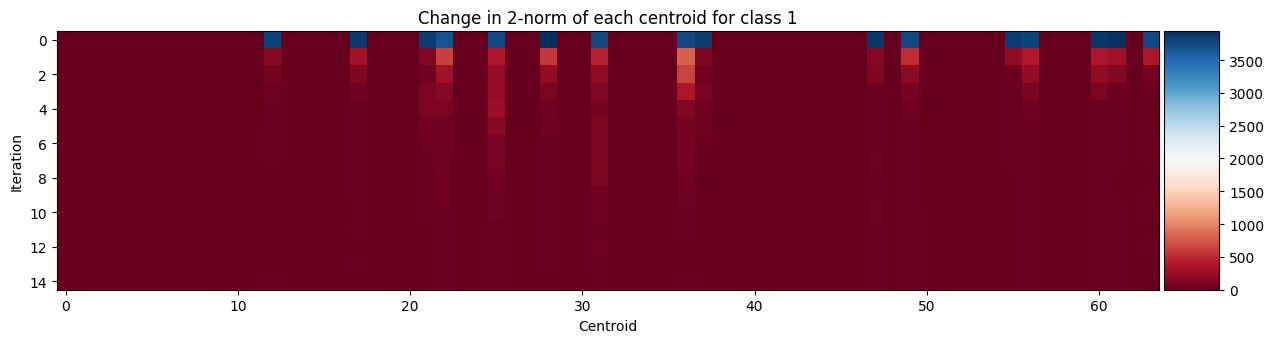

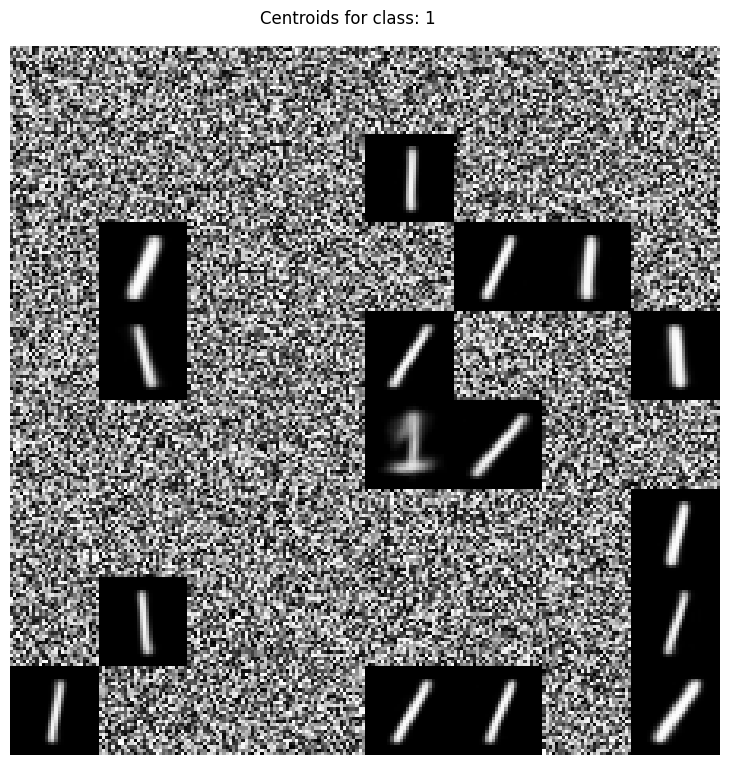

In [170]:
np.random.seed(42)

# Store the centroids sequentially
centroids = np.zeros((M*10, 784))
diff = np.zeros((N, M*10))

# Create labels for centroids
centroids_lab = np.zeros(M*10, dtype=int)
for i in range(10):
    centroids_lab[i*M:(i+1)*M] = [i]*M

# Perform clustering on each class
for i in range(10):
    centroids_class, diff_class = k_means(data=trainv_by_class[i], k=M, max_iterations=N, init_type="uniform")

    centroids[i*M:(i+1)*M] = centroids_class
    diff[:, i*M:(i+1)*M] = diff_class

n=1
display_convergence(diff, n, M)
display_centroids(centroids, n, M)


knn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=1)
nn_idx = knn_idx[:, 0]

nn_pred = centroids_lab[nn_idx]

conf_matrix = generate_conf_matrix(nn_pred, testlab)
total_error_rate, class_error_rate = calc_error_rate(conf_matrix)
print(f"NN total error rate: {total_error_rate:.2%}")


### Gaussian init

NN total error rate: 4.53%


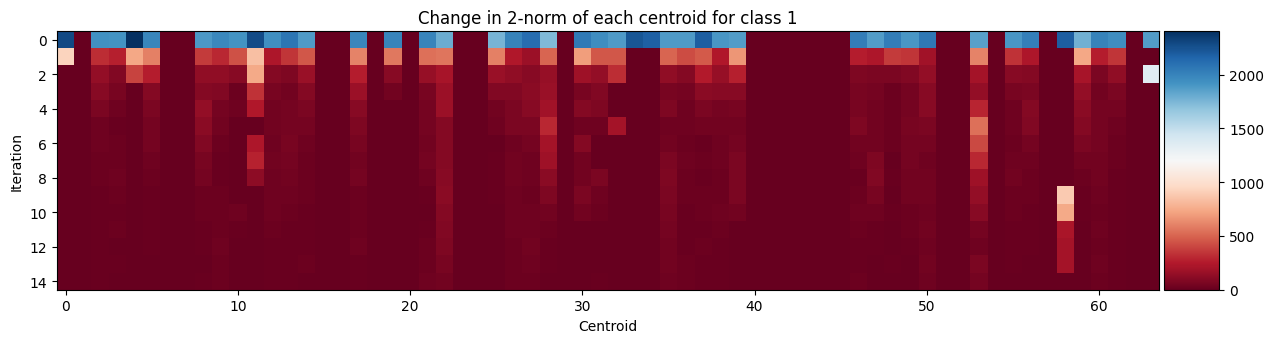

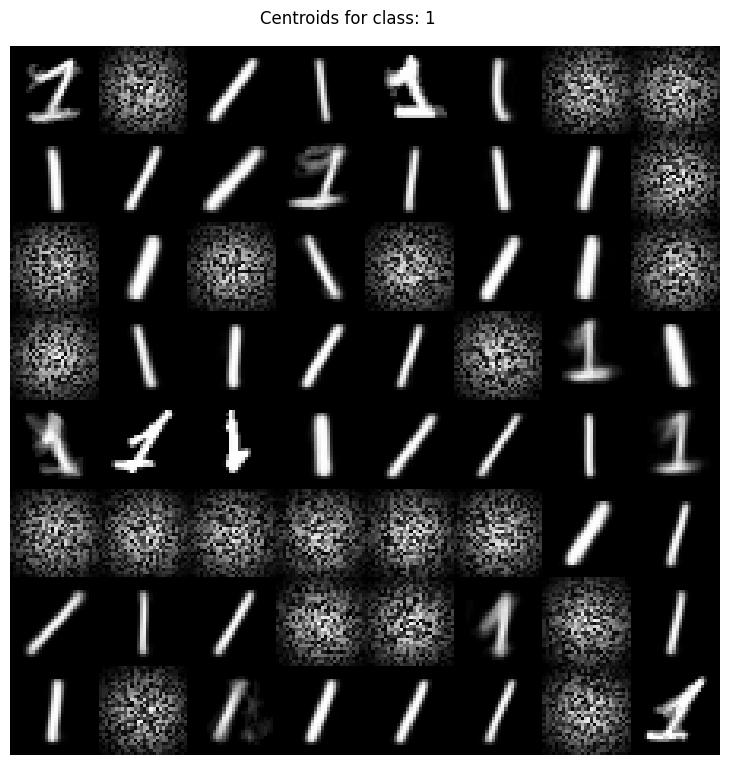

In [172]:
np.random.seed(42)
# Store the centroids sequentially
centroids = np.zeros((M*10, 784))
diff = np.zeros((N, M*10))

# Create labels for centroids
centroids_lab = np.zeros(M*10, dtype=int)
for i in range(10):
    centroids_lab[i*M:(i+1)*M] = [i]*M

# Perform clustering on each class
for i in range(10):
    centroids_class, diff_class = k_means(data=trainv_by_class[i], k=M, max_iterations=N, init_type="gaussian")

    centroids[i*M:(i+1)*M] = centroids_class
    diff[:, i*M:(i+1)*M] = diff_class

n=1
display_convergence(diff, n, M)
display_centroids(centroids, n, M)


knn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=1)
nn_idx = knn_idx[:, 0]

nn_pred = centroids_lab[nn_idx]

conf_matrix = generate_conf_matrix(nn_pred, testlab)
total_error_rate, class_error_rate = calc_error_rate(conf_matrix)
print(f"NN total error rate: {total_error_rate:.2%}")


### k++ init

### Scikit learn

Scikit K-means NN total error rate: 4.77%


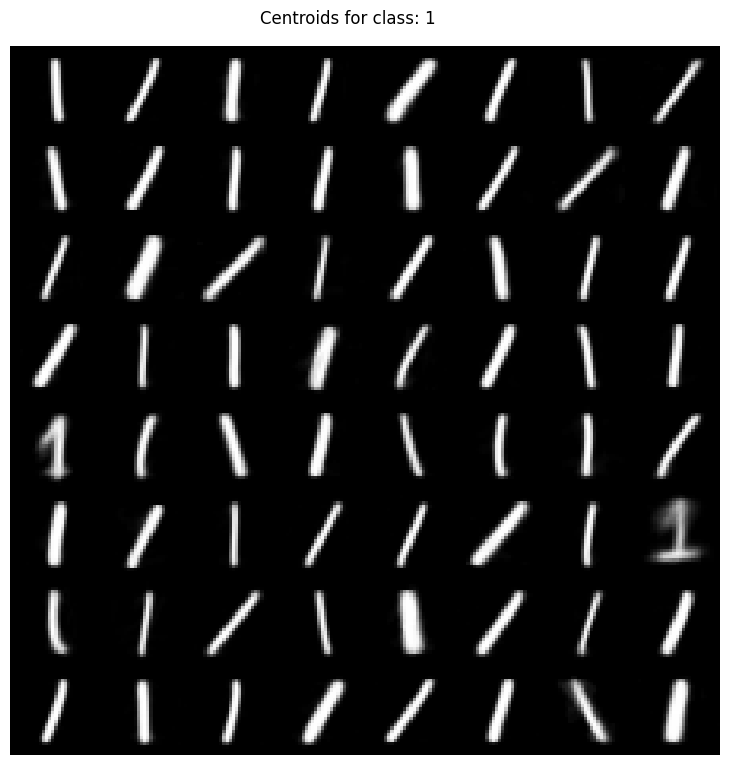

In [175]:
import sklearn.cluster as sk

centroids = np.zeros((M*10, 784))

for i in range(10):
    kmeans = sk.KMeans(n_clusters=M, random_state=42)
    kmeans.fit_predict(trainv_by_class[i])          # Cluster data
    centroids_class = kmeans.cluster_centers_       # Get centroids
    centroids[i*M:(i+1)*M] = centroids_class        # Add centroids

# Create labels for centroids
centroids_lab = np.zeros(M*10, dtype=int)
for i in range(10):
    centroids_lab[i*M:(i+1)*M] = [i]*M


nn_idx = knn(data_to_be_classified=testv, labeled_data=centroids, k=1)[:, 0]

nn_pred = centroids_lab[nn_idx]

conf_matrix = generate_conf_matrix(nn_pred, testlab)
total_error_rate, class_error_rate = calc_error_rate(conf_matrix)
print(f"Scikit K-means NN total error rate: {total_error_rate:.2%}")

n=1
display_centroids(centroids, n, M)